In this exercise you will train a CNN on the FULL Cats-v-dogs dataset. This will require you doing
a lot of data preprocessing because the dataset isn't split into training and validation for you. This exercise you have to add Augmentation to it, and experiment with different parameters to avoid overfitting. This will likely take a lot of time -- as it requires using the full dataset along with augmentation code to edit the data on-the-fly. 

In [2]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [3]:
# unzip the full Cats-v-Dogs dataset to /dataset which will create a tmp/PetImages directory containing 
# subdirectories called 'Cat' and 'Dog' (that's how the original researchers structured it)

path_cats_and_dogs = f"{getcwd()}/dataset/cats-and-dogs.zip"
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [4]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

1500
1500


In [5]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

Write a python function called split_data which takes a SOURCE directory containing the files a TRAINING directory 
that a portion of the files will be copied to a TESTING directory that a portion of the files will be copied to
a SPLIT SIZE to determine the portion. The files should also be randomized, so that the training set is a random
X% of the files, and the test set is the remaining files. SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE
is .9. Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir and 10% of the images will be copied
to the TESTING dir. Also -- All images should be checked, and if they have a zero file length,they will not be copied over.

In [6]:
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [7]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

1350
1350
150
150


In [9]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS. USE AT LEAST 3 CONVOLUTION LAYERS

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid') 
])
model.summary()
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

#### NOTE:

In the cell below you **MUST** use a batch size of 10 (`batch_size=10`) for the `train_generator` and the `validation_generator`. Using a batch size greater than 10 will exceed memory limits on the Coursera platform.

In [10]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=10,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=10,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [11]:
history = model.fit_generator(train_generator,
                              epochs=3,
                              verbose=1,
                              validation_data=validation_generator,
                              )

Epoch 1/3
270/270 [==============================] - 121s 447ms/step - loss: 0.7463 - acc: 0.5422 - val_loss: 0.6736 - val_acc: 0.5800
Epoch 2/3
270/270 [==============================] - 108s 401ms/step - loss: 0.6799 - acc: 0.6089 - val_loss: 0.6249 - val_acc: 0.6333
Epoch 3/3
270/270 [==============================] - 108s 402ms/step - loss: 0.6716 - acc: 0.6148 - val_loss: 0.6191 - val_acc: 0.6333


Text(0.5, 1.0, 'Training and validation loss')

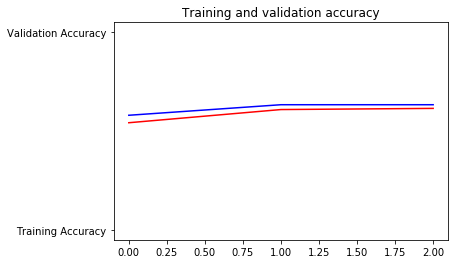

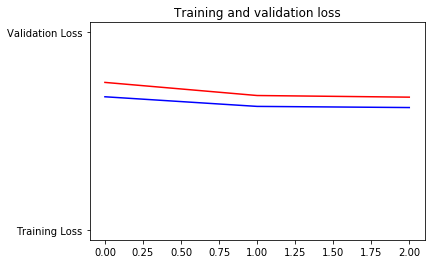

In [12]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))    # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')